In [153]:
import torch
import timeit
import matplotlib.pyplot as plt
import numpy as np

from pprint import pprint
from copy import deepcopy as dc

import pandas as pd 
import wandb
api = wandb.Api()

from pathlib import Path
home = str(Path.home())

# Define the standard plotting colours.
color_names = [
    "tab:blue",
    "tab:orange",
    "tab:green",
    "tab:red",
    "tab:purple",
    "tab:brown",
    "tab:pink",
    "tab:gray",
    "tab:olive",
    "tab:cyan"
]

color_names = color_names * 10

In [154]:
# # Project is specified by <entity/project-name>
# runs = api.runs("andrewwarrington/fivo-aux-beta")

# summary_list, config_list, name_list = [], [], []
# for run in runs: 
#     # .summary contains the output keys/values for metrics like accuracy.
#     #  We call ._json_dict to omit large files 
#     summary_list.append(run.summary._json_dict)

#     # .config contains the hyperparameters.
#     #  We remove special values that start with _.
#     config_list.append(
#         {k: v for k,v in run.config.items()
#           if not k.startswith('_')})

#     # .name is the human-readable name of the run.
#     name_list.append(run.name)

# runs_df = pd.DataFrame({
#     "summary": summary_list,
#     "config": config_list,
#     "name": name_list
#     })

# runs_df.to_csv("project.csv")

# Get individual run.

In [155]:
def get_experiment_from_wandb(project, exp_tag, exp_key=None, exp_val=None):

    # Grab all the runs.
    runs = api.runs(project)
    filtered_runs = []
    filtered_histories = []
    for _run in runs: 
        try:
            # if _run.config['group'] == exp_tag:
            if _run.group == exp_tag:
                filtered_runs.append(_run)
                filtered_histories.append(_run.history(samples=99999999))  # Run with some token large number to grab all the samples.  Can be very slow.
        except:
            pass
    print(len(filtered_runs))
    
    # Throw and error if there were no runs.
    if len(filtered_runs) == 0:
        raise RuntimeError("No experiments found.  Check the exp_tag.")


    # Now re-grab the runs and make sure they all share keys.
    key_runs = api.runs(project)
    keys = []
    for _run in key_runs: 
        try:
            if _run.group == exp_tag:
                keys.append(_run.scan_history().__next__().keys())
        except Exception as err:
            pass

    assert all([keys[0] == _k for _k in keys]), 'Keys are not shared.'
    
    
    # Go and get everything.
    values = []
    lengths = []
    for _hist in filtered_histories:
        _values = []
        for _v in _hist:
            _values.append(_v)
        values.append(_values)
        lengths.append(len(_values))
    min_Length = np.min(lengths)
        
    return values, min_Length, filtered_histories


In [156]:
# filtered_histories = run.history(samples=99999999)  # Run with some token large number to grab all the samples.  Can be very slow.
# filtered_histories = [_r.scan_history() for _r in filtered_runs]  # Default to using fewer samples.

plot_styles = ['-', '--', ':', '-.'] * 10

# Project is specified by <entity/project-name>
project = "andrewwarrington/fivo-aux-beta"


# exp_tag = ['gdm-v2.1.0-sgr-pqr', ]
# save_tag = 'gdm-v2-1-1'

# exp_tag = ['gdm-v2.1.0-sgr-pqr', 'gdm-v2.1.0-nsgr-pqr']
# save_tag = 'gdm-v2-1'

# exp_tag = ['gdm-v2.0.0-sgr', 'gdm-v2.0.0-no-sgr', ]
# save_tag = 'gdm-v2-0'

exp_tag = ['debug-1', ]
save_tag = 'debug-1'

filtered_histories = []
for _tag in exp_tag:
    _, _, _filtered_histories = get_experiment_from_wandb(project, _tag)
    filtered_histories.append(_filtered_histories)

pprint("Keys:")
pprint(list(filtered_histories[0][0].keys()))

10
'Keys:'
['step',
 'params_p_true.dynamics_bias',
 'params_p_pred.dynamics_bias',
 'small_lml_variance_fivo',
 '_step',
 'params_q_pred.head_mean_fn_bias',
 'params_r_pred.head_mean_fn_kernel',
 'small_lml_variance_bpf_true',
 'params_r_pred.head_mean_fn_bias',
 'params_q_pred.head_mean_fn_kernel',
 'small_lml_mean_em_true',
 'params_r_pred.head_log_var_fn_bias_(EXP)',
 'params_q_pred.head_log_var_fn_bias_(EXP)',
 '_runtime',
 'small_fivo_bound',
 'epoch',
 'small_lml_mean_bpf_true',
 'pred_fivo_bound',
 'pred_lml',
 'small_lml_mean_fivo',
 '_timestamp']


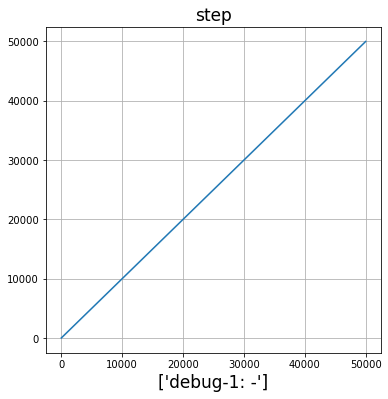

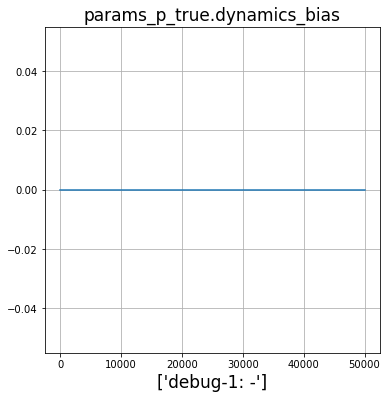

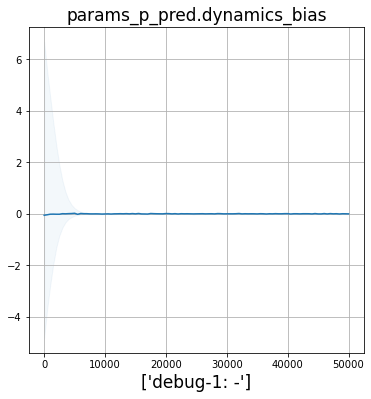

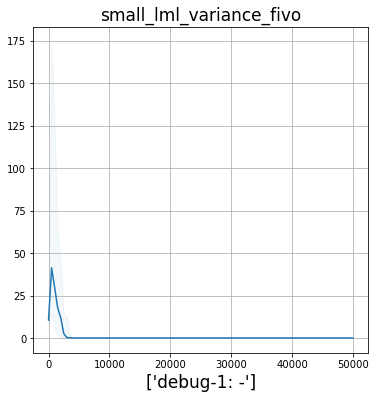

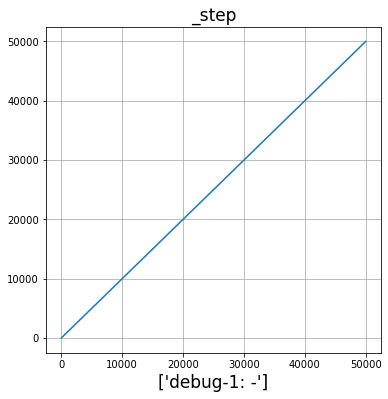

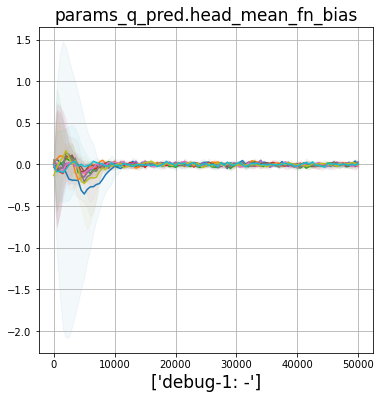

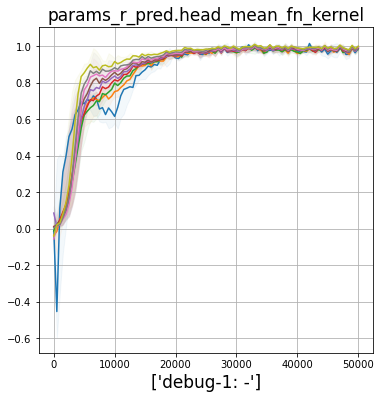

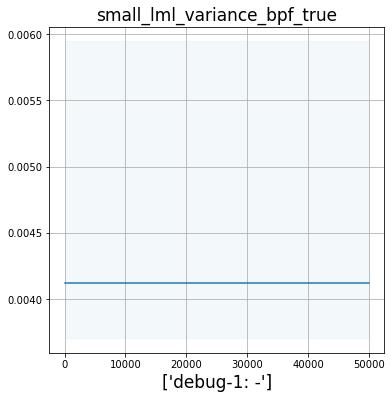

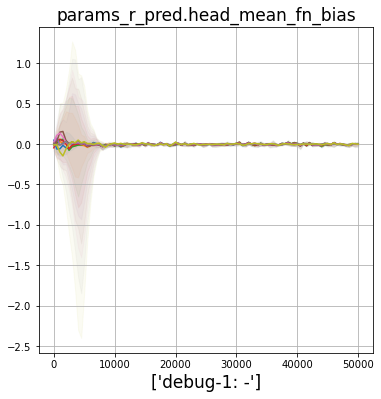

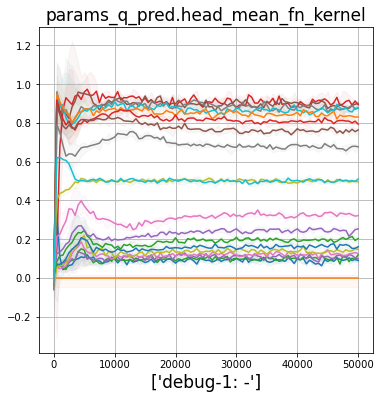

small_lml_mean_em_true failed.
'<' not supported between instances of 'NoneType' and 'NoneType'


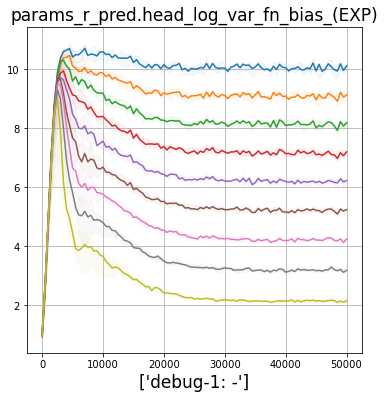

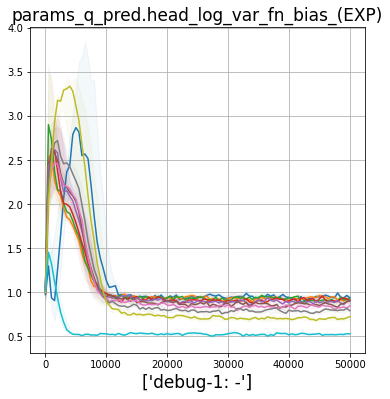

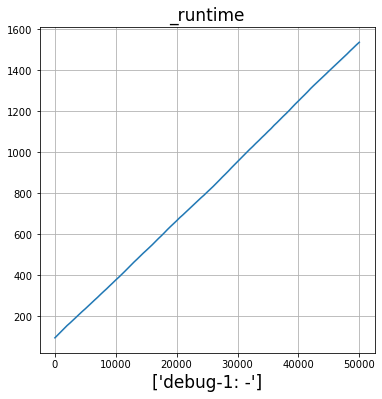

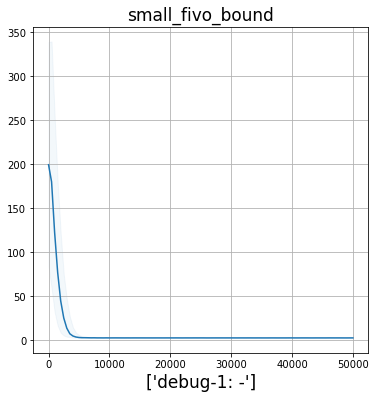

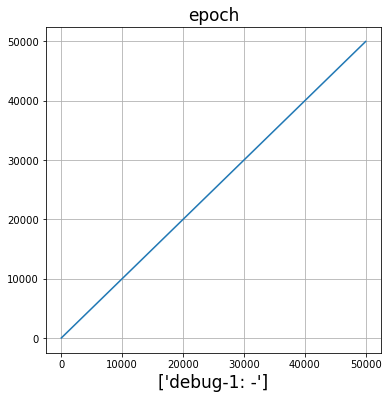

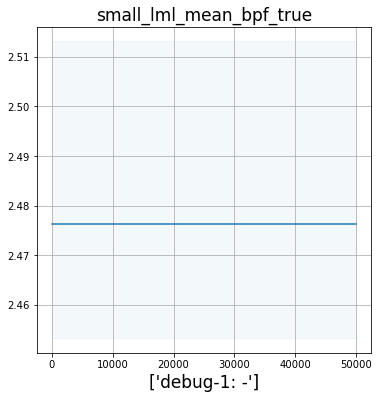

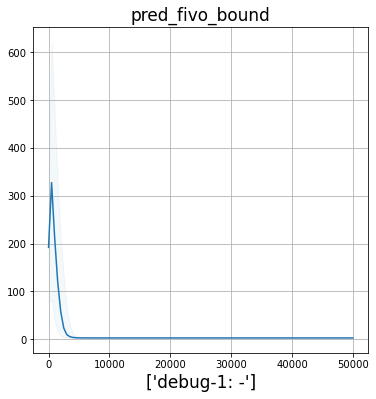

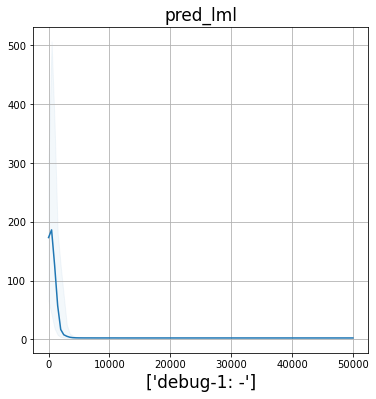

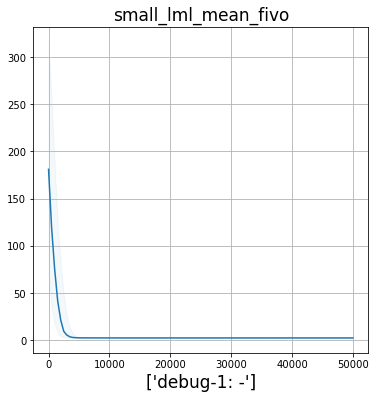

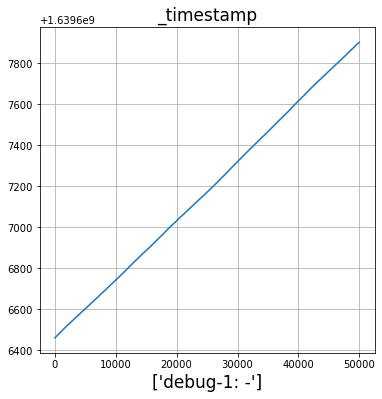

In [157]:
all_keys_to_plot = list(filtered_histories[0][0].keys())  # ['params_q_pred.head_mean_fn_kernel',]  # {list(filtered_histories[0][0].keys()), [STR,]}

for key_to_plot in all_keys_to_plot:

    x = filtered_histories[0][0].get('step').values.squeeze()
    
    try:
        f = plt.figure(figsize=(6,6))

        for _i, _k in enumerate(exp_tag):

            to_plot = []
            for _j in range(len(filtered_histories[_i])):
                to_plot.append(np.stack(filtered_histories[_i][_j].get(key_to_plot).values.squeeze()))

            h = np.stack(to_plot).squeeze()
            mu = np.quantile(h, 0.50, axis=0)
            lq = np.quantile(h, 0.25, axis=0)
            uq = np.quantile(h, 0.75, axis=0)

            mu = mu.reshape(len(mu), -1)
            lq = lq.reshape(len(lq), -1)
            uq = uq.reshape(len(uq), -1)

            for _j in range(len(mu.T)):
                plt.plot(x, mu[:, _j], c=color_names[_j], linestyle=plot_styles[_i])
                plt.fill_between(x, lq[:, _j], uq[:, _j], color=color_names[_j], alpha=0.05)
            plt.grid(True)

        plt.xlabel(['{}: {}'.format(_a, _b) for _a, _b in zip(exp_tag, plot_styles)], fontsize=17)
        plt.title(key_to_plot, fontsize=17)

        plt.savefig('{}/Downloads/{}_{}.pdf'.format(home, save_tag, key_to_plot))
        plt.pause(0.1)
    except Exception as err:
        print(key_to_plot, 'failed.')
        print(err)
        plt.close(f)

In [158]:
plt.plot(x, mu[:, _j], c=color_names[_j], linestyle=plot_styles[_i])

TypeError: list indices must be integers or slices, not str

In [112]:
_i

'_j'

In [ ]:
filtered_histories[_i][_j].get(key_to_plot).values[1:]

In [15]:
filtered_histories[_i][_j].get(key_to_plot).values[1:]

TypeError: list indices must be integers or slices, not str

In [114]:
print(_i)

_i


In [38]:
h.shape

(10, 101, 9)

In [19]:
_i = 0
print(np.arange(10)[_i])

0
